In [9]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [10]:
import pandas as pd
import numpy as np

df_2016_17 = pd.read_sql_query(
    "SELECT * FROM ACGR WHERE Year = '2016-17' and CharterSchool = 'No ' and DASS = 'No '",
    con,
)
df_2017_18 = pd.read_sql_query(
    "SELECT * FROM ACGR WHERE Year = '2017-18' and CharterSchool = 'No ' and DASS = 'No '",
    con,
)
df_2018_19 = pd.read_sql_query(
    "SELECT * FROM ACGR WHERE Year = '2018-19' and CharterSchool = 'No ' and DASS = 'No '",
    con,
)
df_2019_20 = pd.read_sql_query(
    "SELECT * FROM ACGR WHERE Year = '2019-20' and CharterSchool = 'No ' and DASS = 'No '",
    con,
)
df_2020_21 = pd.read_sql_query(
    "SELECT * FROM ACGR WHERE Year = '2020-21' and CharterSchool = 'No ' and DASS = 'No '",
    con,
)
df_2021_22 = pd.read_sql_query(
    "SELECT * FROM ACGR WHERE Year = '2021-22' and CharterSchool = 'No ' and DASS = 'No '",
    con,
)
df_2022_23 = pd.read_sql_query(
    "SELECT * FROM ACGR WHERE Year = '2022-23' and CharterSchool = 'No ' and DASS = 'No '",
    con,
)
df_2023_24 = pd.read_sql_query(
    "SELECT * FROM ACGR WHERE Year = '2023-24' and CharterSchool = 'No ' and DASS = 'No '",
    con,
)

year_df_mapping = {
    2016: df_2016_17,
    2017: df_2017_18,
    2018: df_2018_19,
    2019: df_2019_20,
    2020: df_2020_21,
    2021: df_2021_22,
    2022: df_2022_23,
    2023: df_2023_24,
}
grad_rate_columns_to_drop = [
    col
    for col in df_2016_17.columns
    if col.startswith("Dropout")
    or col.startswith("RegHSDiploma")
    or col.startswith("UniReqs")
]
csu_rate_columns_to_drop = [
    col
    for col in df_2016_17.columns
    if col.startswith("UniReqs")
    or col.startswith("Dropout")
    or col.startswith("RegHSDiploma")
]

## XGBoost


### Cross-Validated Grad Rate


In [11]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance
from modeling.utils.xgboost import (
    plot_top_k_features,
    plot_feature_avg_variance,
    plot_feature_time_series,
)

cv_xgb_models = {}

target_column = "RegHSDiplomaRate"

for year, year_df in year_df_mapping.items():

    year_df.replace("*", np.nan, inplace=True)
    year_df["Year"] = year_df["Year"].astype(str).str.split("-").str[0]
    year_df = year_df.apply(pd.to_numeric, errors="coerce")
    year_df[target_column] = pd.to_numeric(year_df[target_column], errors="coerce")

    cv_result = cross_validate_xgboost(
        df=year_df,
        target_column=target_column,
        columns_to_drop=[target_column] + grad_rate_columns_to_drop,
        n_splits=5,
        print_results=True,
        n_jobs=-1,
    )

    cv_xgb_models[year] = cv_result


Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2016:
RMSE: 4.5261 ± 0.1299
MAE: 2.5136 ± 0.0298
R^2: 0.8973 ± 0.0091
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2017:
RMSE: 3.9605 ± 0.2260
MAE: 2.1872 ± 0.0609
R^2: 0.9106 ± 0.0089
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2018:
RMSE: 3.7890 ± 0.1964
MAE: 1.9946 ± 0.0374
R^2: 0.9174 ± 0.0069
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2019:
RMSE: 4.5142 ± 0.3918
MAE: 2.3055 ± 0.0436
R^2: 0.9162 ± 0.0144
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2020:
RMSE: 4.7136 ± 0.4818
MAE: 2.4016 ± 0.0890
R^2: 0.8747 ± 0.0223
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2021:
RMSE: 3.6049 ± 0.1308
MAE: 1.8712 ± 0.0325
R^2: 0.9113 ± 0.0042
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2022:
RMSE: 4.3123 ± 0.4508
MAE: 2.0113 ± 0.0807
R^2: 0.8856 ± 0.0145
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2023:
RMSE: 5.8358 ± 0.2574
MA

<Figure size 1400x600 with 0 Axes>

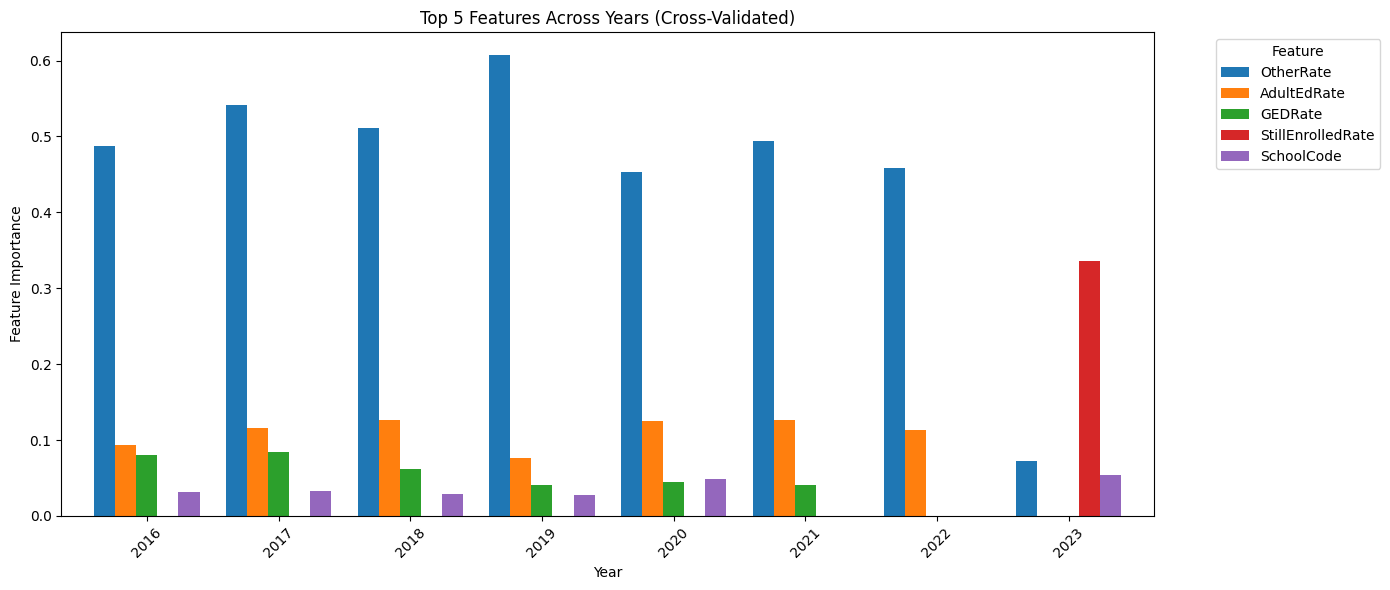

<Figure size 1400x600 with 0 Axes>

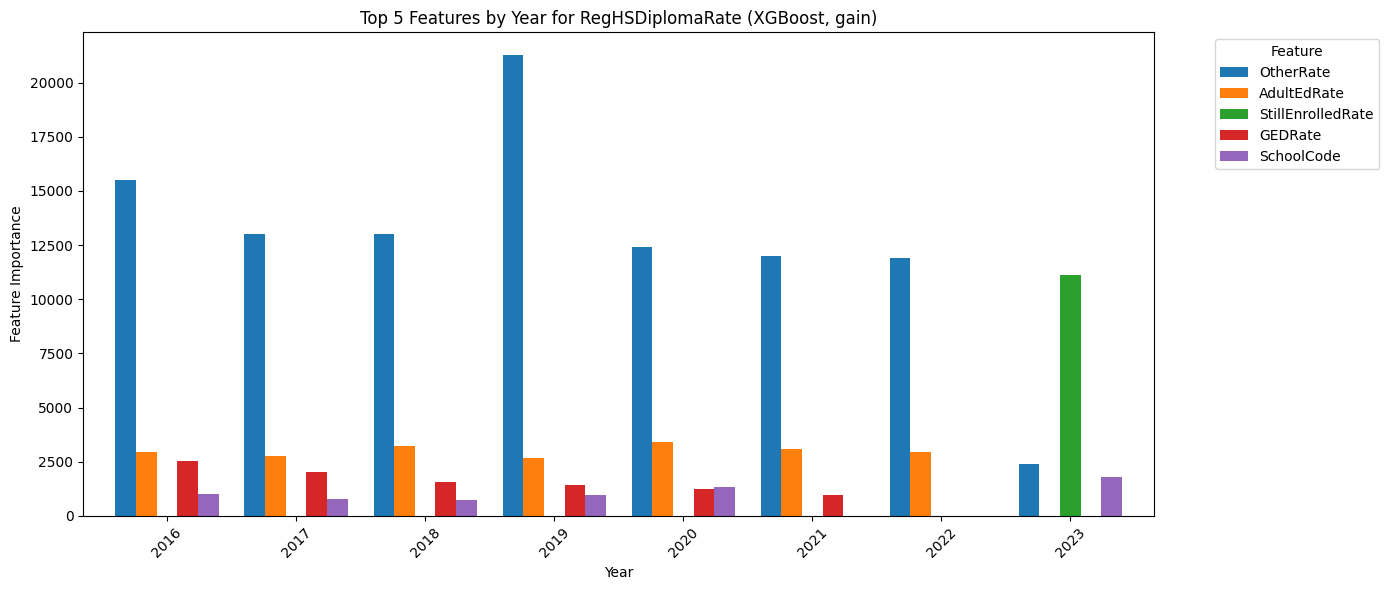

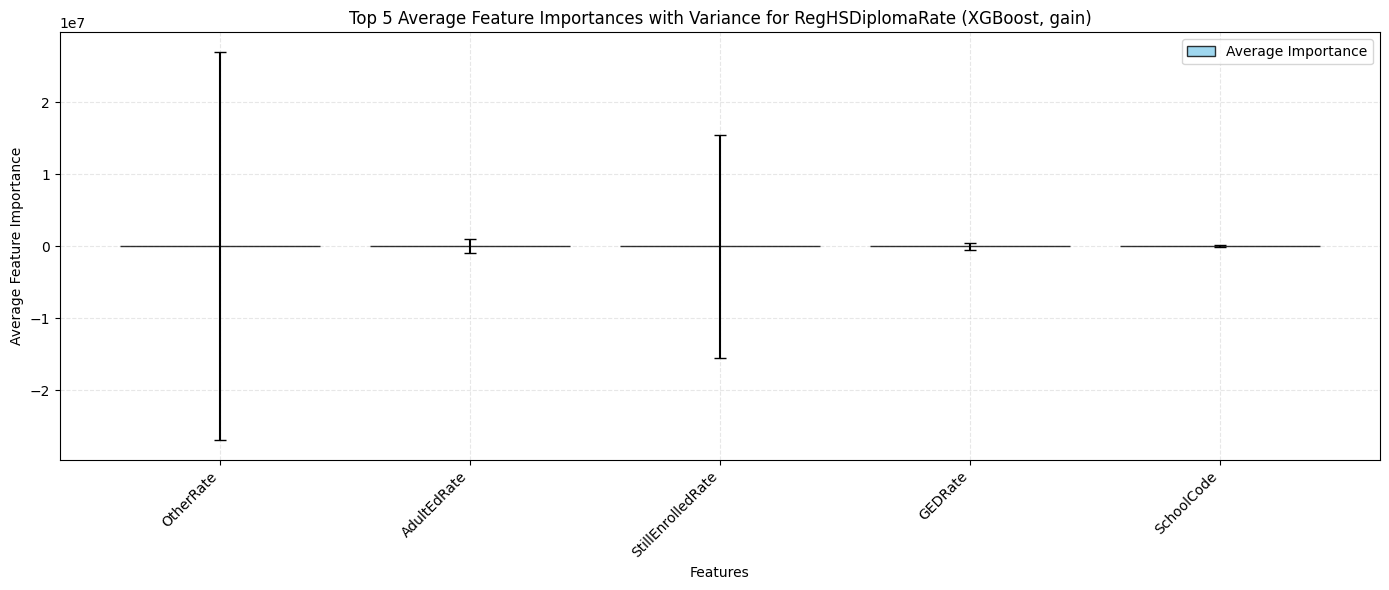

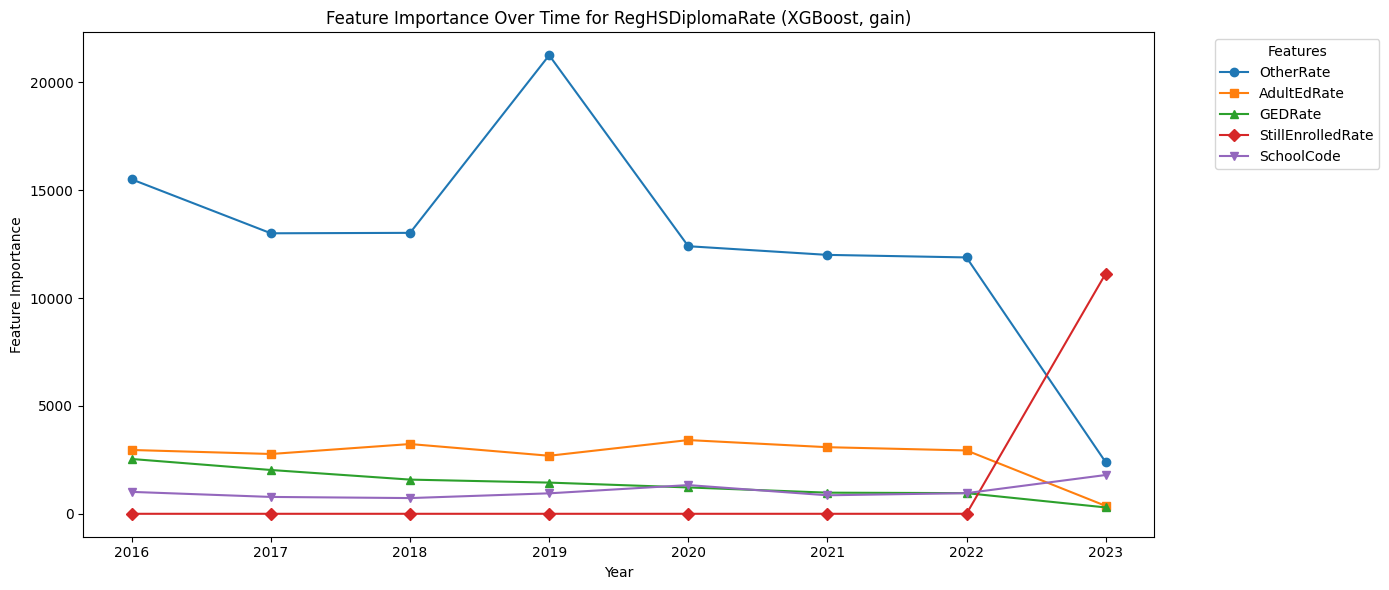

In [12]:
k = 5
top_features = plot_cv_feature_importance(cv_xgb_models, top_n=k)
plot_top_k_features(cv_xgb_models, "XGBoost", "gain", target_column, k=k)
plot_feature_avg_variance(cv_xgb_models, "XGBoost", "gain", target_column, k=k)
plot_feature_time_series(cv_xgb_models, "XGBoost", "gain", target_column, top_features)

### Cross-Validated CSU/UC Readiness Rate


In [13]:
from modeling.utils.xgboost import cross_validate_xgboost, plot_cv_feature_importance
from modeling.utils.xgboost import (
    plot_top_k_features,
    plot_feature_avg_variance,
    plot_feature_time_series,
)

cv_xgb_models = {}

target_column = "UniReqsPercent"


for year, year_df in year_df_mapping.items():

    year_df.replace("*", np.nan, inplace=True)
    year_df["Year"] = year_df["Year"].astype(str).str.split("-").str[0]
    year_df = year_df.apply(pd.to_numeric, errors="coerce")
    year_df[target_column] = pd.to_numeric(year_df[target_column], errors="coerce")

    cv_result = cross_validate_xgboost(
        df=year_df,
        target_column=target_column,
        columns_to_drop=csu_rate_columns_to_drop,
        n_splits=5,
        print_results=True,
        n_jobs=-1,
    )

    cv_xgb_models[year] = cv_result

Cross-Validation Results for UniReqsPercent (5 folds) for 2016:
RMSE: 12.1280 ± 0.1659
MAE: 8.9864 ± 0.0800
R^2: 0.7269 ± 0.0045
Cross-Validation Results for UniReqsPercent (5 folds) for 2017:
RMSE: 12.9213 ± 0.0581
MAE: 9.4215 ± 0.0974
R^2: 0.7029 ± 0.0050
Cross-Validation Results for UniReqsPercent (5 folds) for 2018:
RMSE: 12.6842 ± 0.2477
MAE: 9.3301 ± 0.1212
R^2: 0.7176 ± 0.0109
Cross-Validation Results for UniReqsPercent (5 folds) for 2019:
RMSE: 12.3260 ± 0.2455
MAE: 9.1918 ± 0.1143
R^2: 0.7285 ± 0.0090
Cross-Validation Results for UniReqsPercent (5 folds) for 2020:
RMSE: 12.7437 ± 0.1368
MAE: 9.3887 ± 0.1018
R^2: 0.7188 ± 0.0093
Cross-Validation Results for UniReqsPercent (5 folds) for 2021:
RMSE: 11.6164 ± 0.1049
MAE: 8.6075 ± 0.0402
R^2: 0.7648 ± 0.0050
Cross-Validation Results for UniReqsPercent (5 folds) for 2022:
RMSE: 11.7297 ± 0.2249
MAE: 8.6337 ± 0.1525
R^2: 0.7712 ± 0.0052
Cross-Validation Results for UniReqsPercent (5 folds) for 2023:
RMSE: 11.2564 ± 0.2156
MAE: 8.344

<Figure size 1400x600 with 0 Axes>

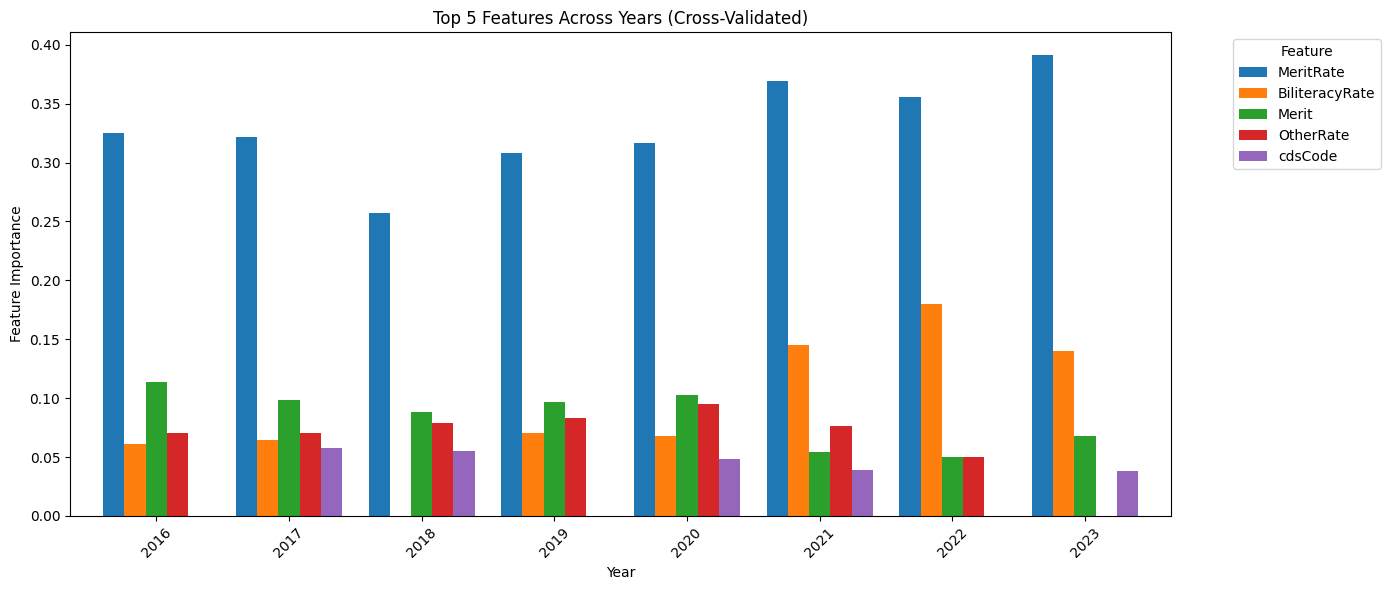

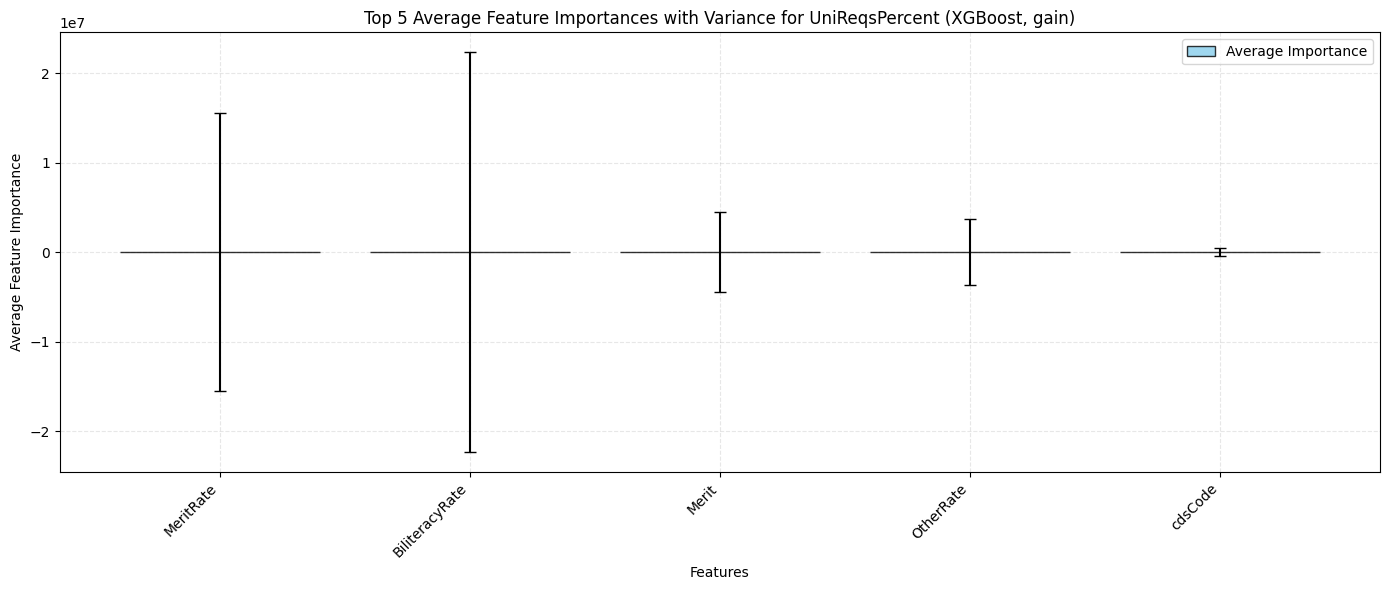

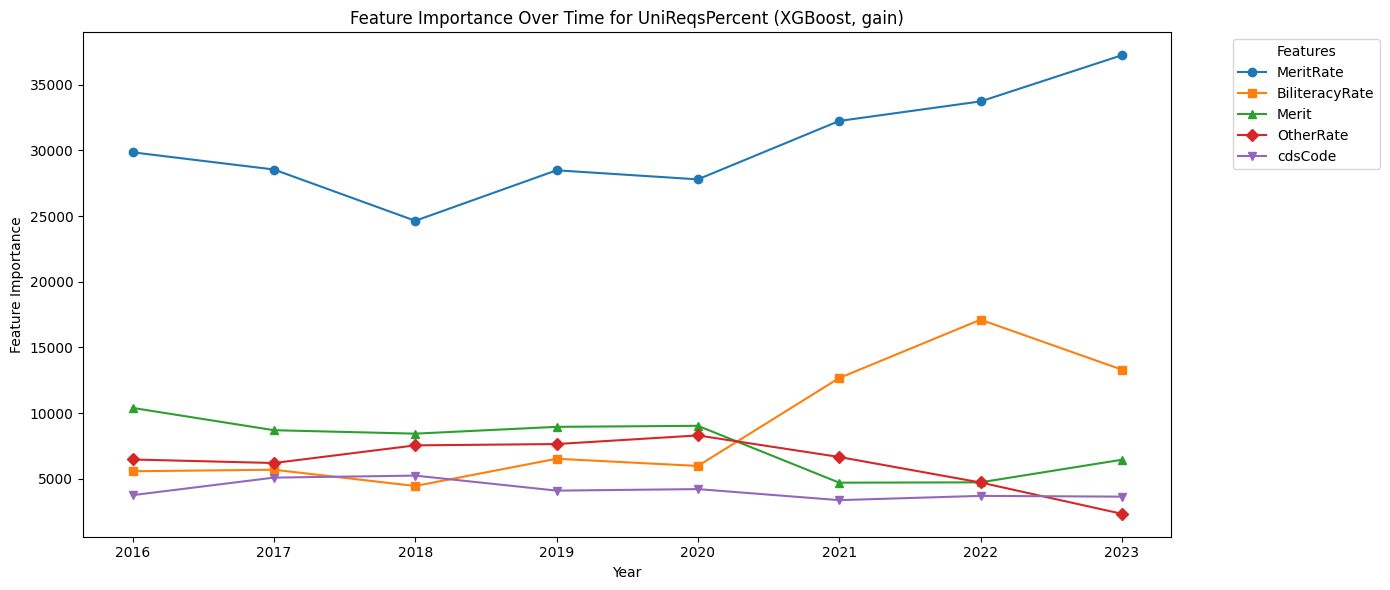

In [14]:
top_features = plot_cv_feature_importance(cv_xgb_models, top_n=5)
plot_feature_avg_variance(cv_xgb_models, "XGBoost", "gain", target_column)
plot_feature_time_series(cv_xgb_models, "XGBoost", "gain", target_column, top_features)

## Random Forest


### Cross Validated Grad Rate


In [15]:
from modeling.utils.randomforest import (
    cross_validate_random_forest,
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
)

cv_models = {}

target_variable = "RegHSDiplomaRate"

for year, year_df in year_df_mapping.items():

    year_df.replace("*", np.nan, inplace=True)
    year_df["Year"] = year_df["Year"].astype(str).str.split("-").str[0]
    year_df = year_df.apply(pd.to_numeric, errors="coerce")
    year_df[target_column] = pd.to_numeric(year_df[target_column], errors="coerce")

    cv_result = cross_validate_random_forest(
        df=year_df,
        target_column=target_variable,
        columns_to_drop=grad_rate_columns_to_drop,
        n_splits=5,
        print_results=True,
        n_jobs=-1,
    )

    cv_models[year] = cv_result

Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2016:
RMSE: 5.0658 ± 0.2482
MAE: 2.6218 ± 0.0425
R²: 0.8725 ± 0.0180
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2017:
RMSE: 4.4145 ± 0.3323
MAE: 2.3552 ± 0.0759
R²: 0.8868 ± 0.0150
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2018:
RMSE: 4.4151 ± 0.2432
MAE: 2.1814 ± 0.0290
R²: 0.8852 ± 0.0076
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2019:
RMSE: 4.9170 ± 0.4377
MAE: 2.4118 ± 0.0456
R²: 0.9005 ± 0.0181
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2020:
RMSE: 5.4447 ± 0.4429
MAE: 2.5651 ± 0.0673
R²: 0.8261 ± 0.0157
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2021:
RMSE: 3.9701 ± 0.1348
MAE: 1.9421 ± 0.0403
R²: 0.8890 ± 0.0077
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2022:
RMSE: 4.5812 ± 0.3442
MAE: 2.1556 ± 0.0904
R²: 0.8673 ± 0.0175
Cross-Validation Results for RegHSDiplomaRate (5 folds) for 2023:
RMSE: 5.6648 ± 0.2330
MAE: 3.51

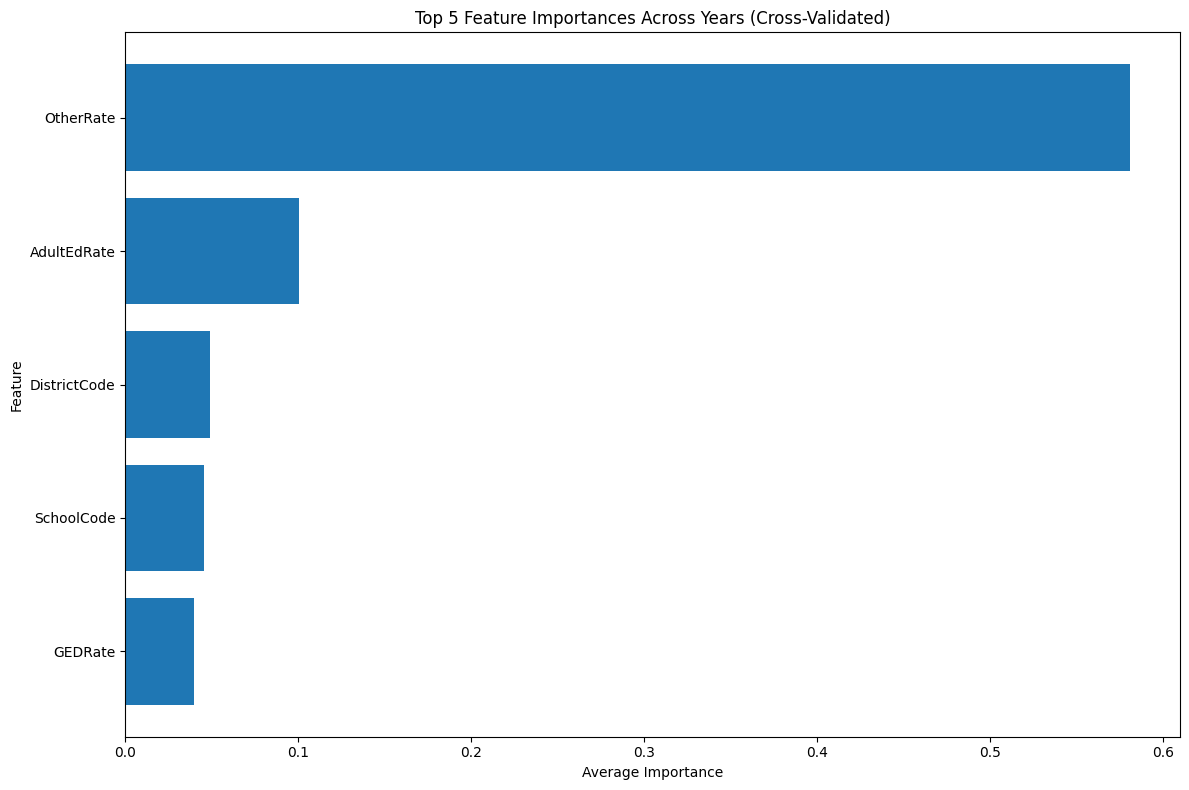

<Figure size 1400x600 with 0 Axes>

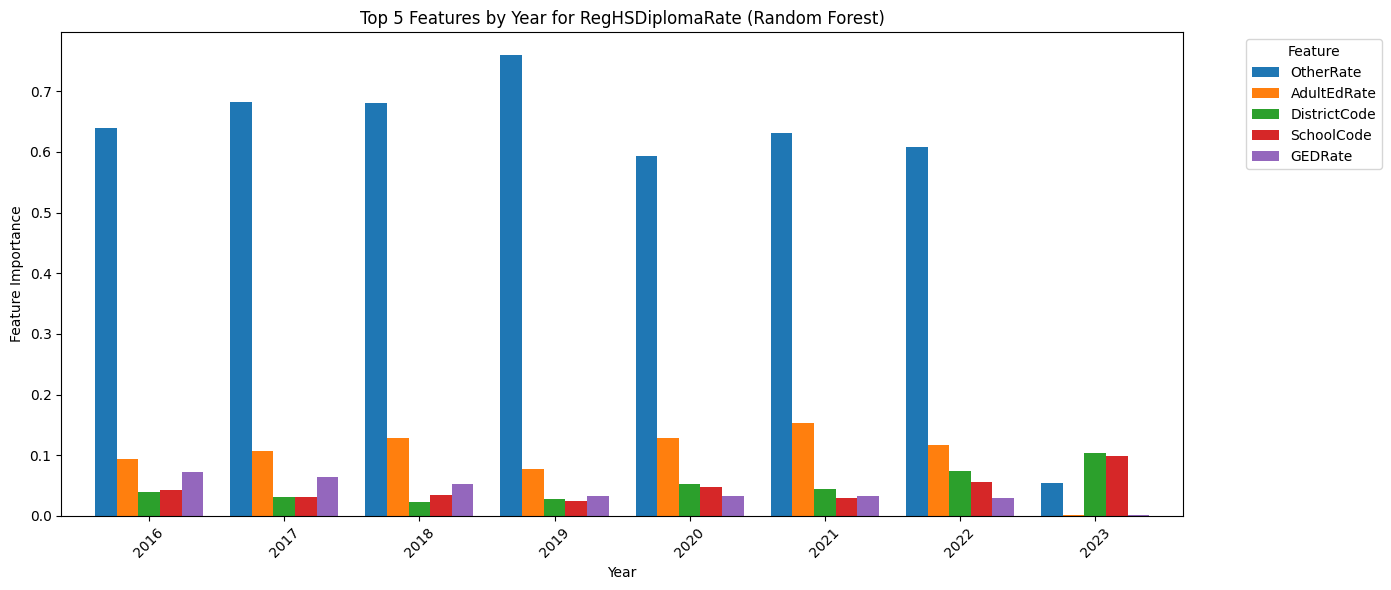

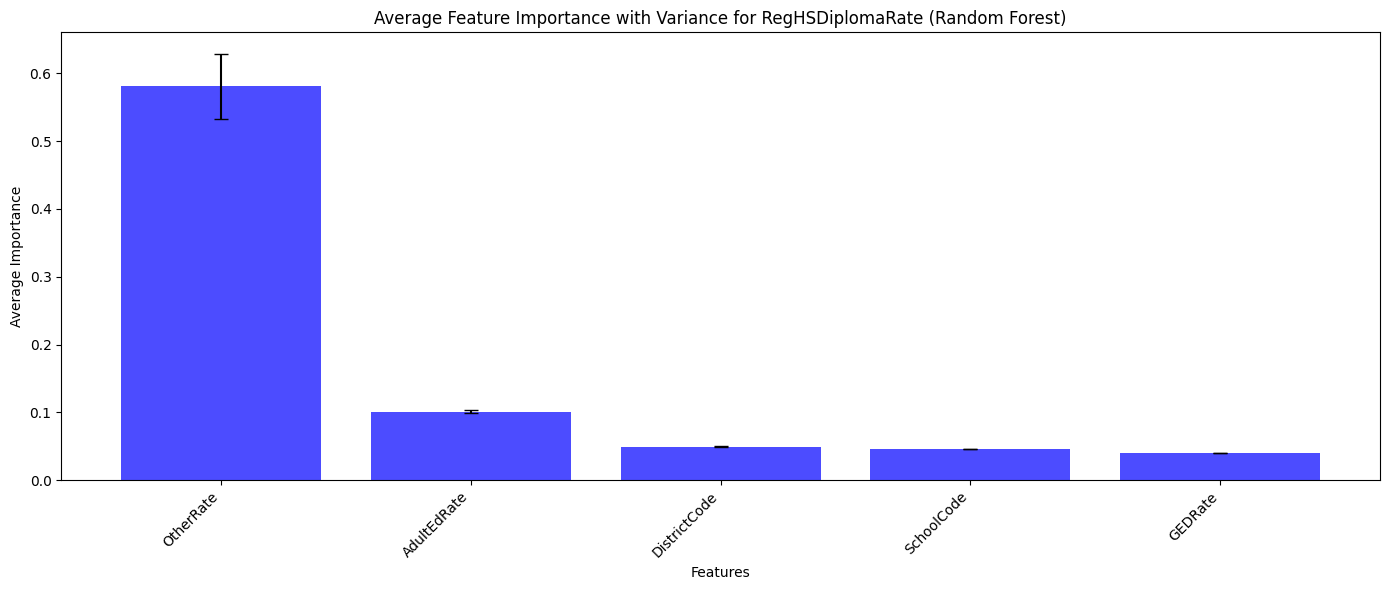

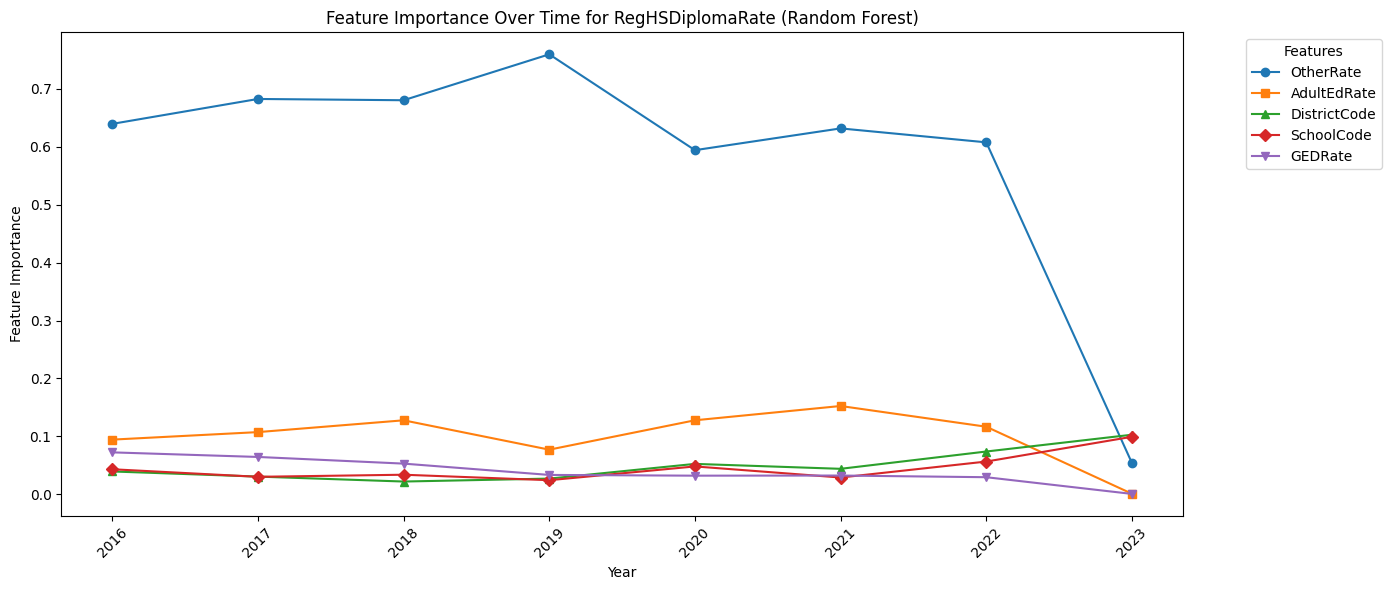

In [16]:
all_top_features = plot_cv_feature_importance_rf(cv_models, top_n=5)

plot_top_k_features_rf(cv_models, target_variable=target_variable, k=5)
plot_feature_avg_variance_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features
)
plot_feature_time_series_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features
)

### Cross Validated CSU/UC Readiness Rate


In [17]:
from modeling.utils.randomforest import (
    cross_validate_random_forest,
    plot_cv_feature_importance_rf,
    plot_top_k_features_rf,
    plot_feature_avg_variance_rf,
    plot_feature_time_series_rf,
)

cv_models = {}

target_variable = "UniReqsPercent"

for year, year_df in year_df_mapping.items():

    year_df.replace("*", np.nan, inplace=True)
    year_df["Year"] = year_df["Year"].astype(str).str.split("-").str[0]
    year_df = year_df.apply(pd.to_numeric, errors="coerce")
    year_df[target_column] = pd.to_numeric(year_df[target_column], errors="coerce")

    cv_result = cross_validate_random_forest(
        df=year_df,
        target_column=target_variable,
        columns_to_drop=csu_rate_columns_to_drop,
        n_splits=5,
        print_results=True,
        n_jobs=-1
    )

    cv_models[year] = cv_result

Cross-Validation Results for UniReqsPercent (5 folds) for 2016:
RMSE: 11.8559 ± 0.2381
MAE: 8.4848 ± 0.1617
R²: 0.7424 ± 0.0086
Cross-Validation Results for UniReqsPercent (5 folds) for 2017:
RMSE: 12.7589 ± 0.0941
MAE: 8.9943 ± 0.0926
R²: 0.7092 ± 0.0077
Cross-Validation Results for UniReqsPercent (5 folds) for 2018:
RMSE: 12.9926 ± 0.2751
MAE: 9.2127 ± 0.0747
R²: 0.7060 ± 0.0119
Cross-Validation Results for UniReqsPercent (5 folds) for 2019:
RMSE: 12.4842 ± 0.3257
MAE: 9.0493 ± 0.1900
R²: 0.7248 ± 0.0141
Cross-Validation Results for UniReqsPercent (5 folds) for 2020:
RMSE: 12.4496 ± 0.0665
MAE: 8.9688 ± 0.0463
R²: 0.7296 ± 0.0074
Cross-Validation Results for UniReqsPercent (5 folds) for 2021:
RMSE: 11.6592 ± 0.1182
MAE: 8.4401 ± 0.0594
R²: 0.7634 ± 0.0061
Cross-Validation Results for UniReqsPercent (5 folds) for 2022:
RMSE: 11.6989 ± 0.2393
MAE: 8.3318 ± 0.1813
R²: 0.7730 ± 0.0086
Cross-Validation Results for UniReqsPercent (5 folds) for 2023:
RMSE: 11.1591 ± 0.2785
MAE: 7.9591 ± 0.1

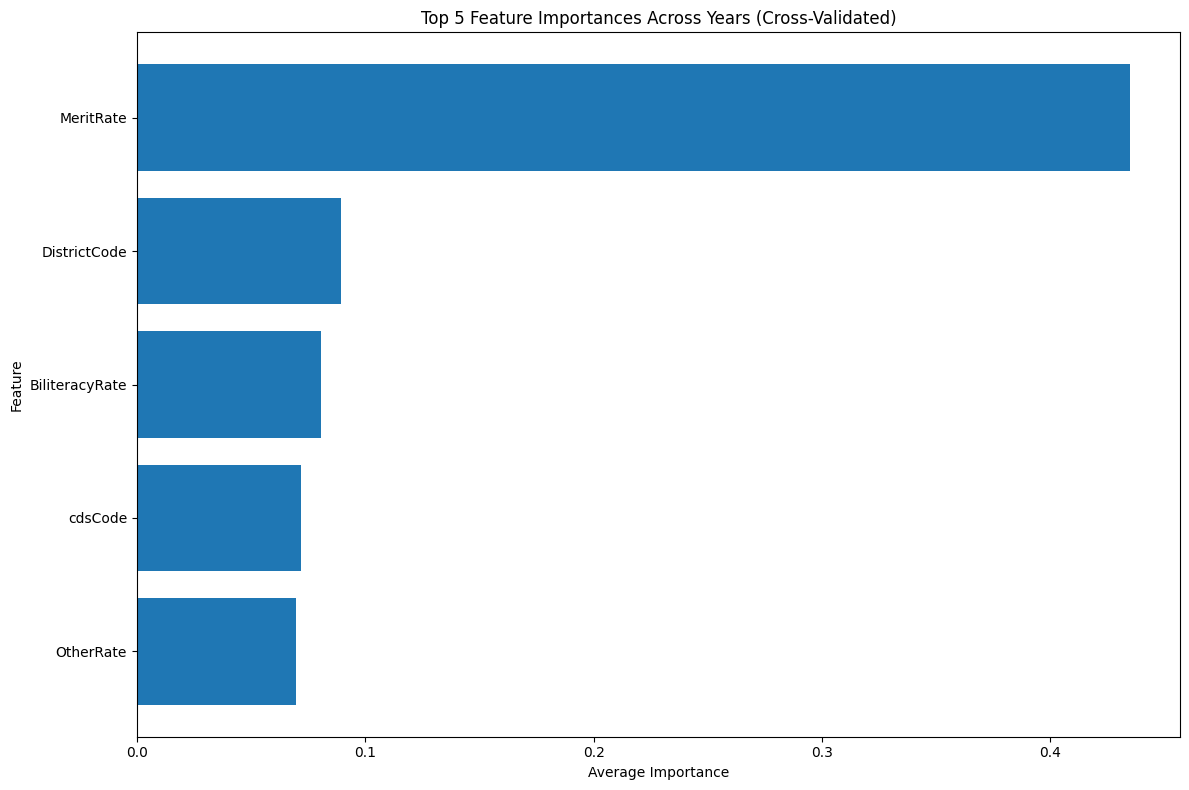

<Figure size 1400x600 with 0 Axes>

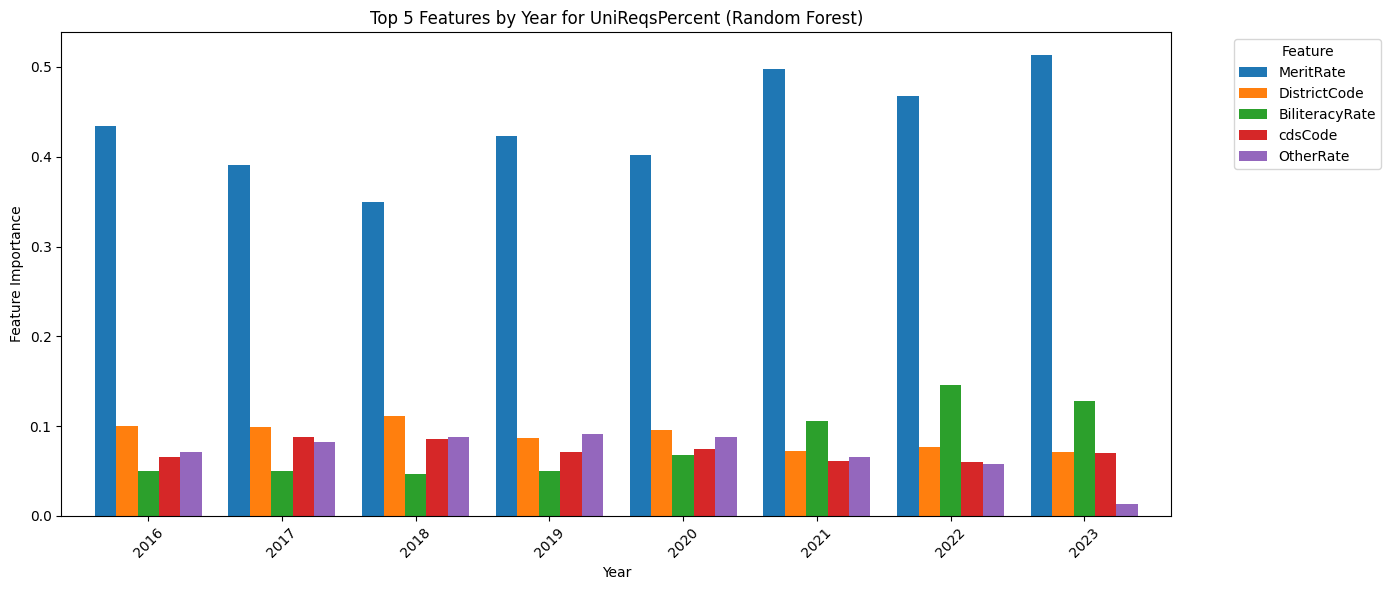

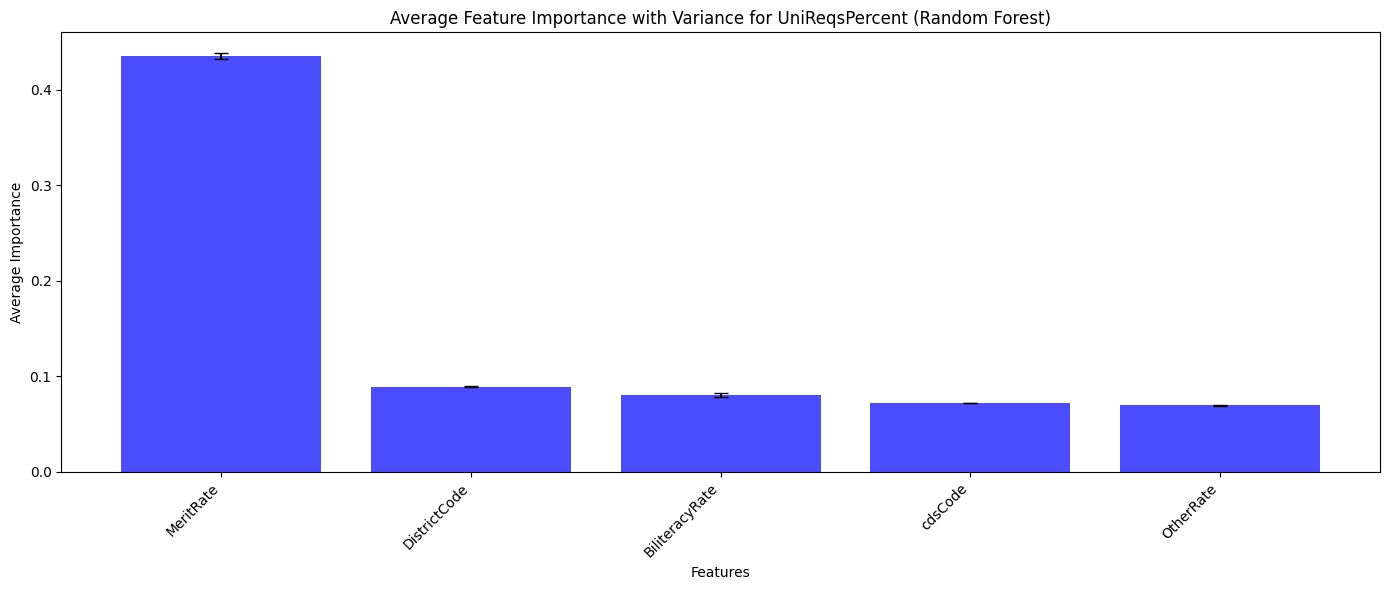

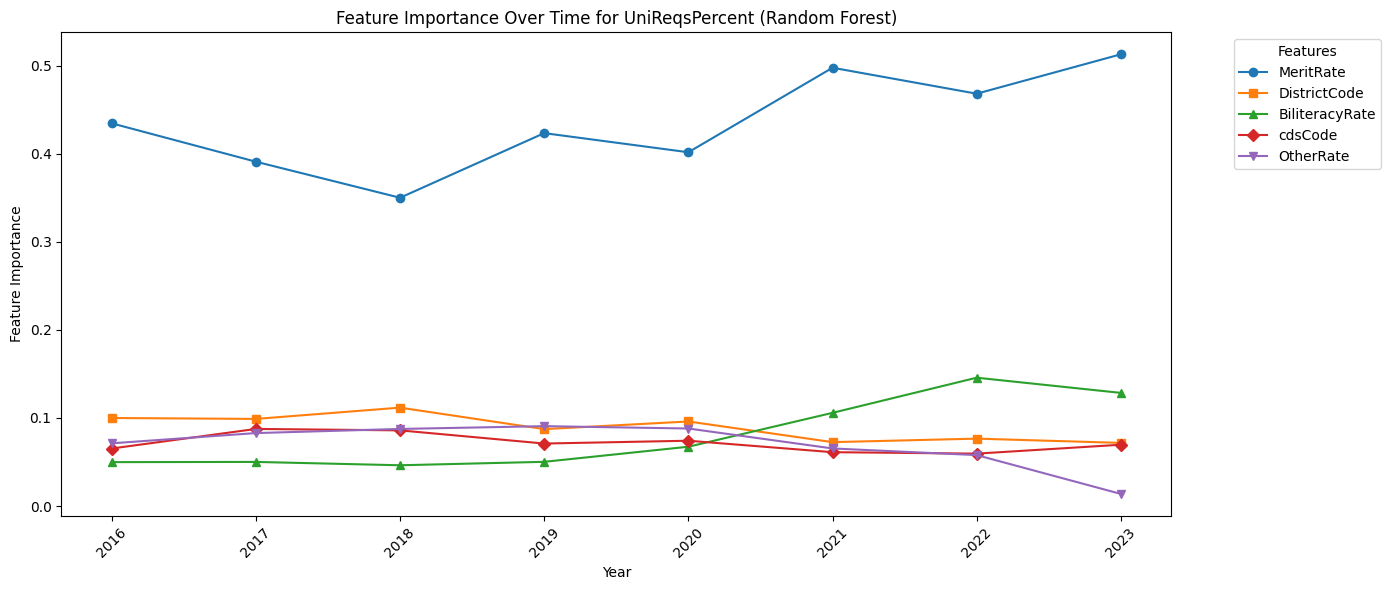

In [18]:
all_top_features = plot_cv_feature_importance_rf(cv_models, top_n=5)
plot_top_k_features_rf(cv_models, target_variable=target_variable, k=5)
plot_feature_avg_variance_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features
)
plot_feature_time_series_rf(
    cv_models, target_variable=target_variable, top_k_features=all_top_features
)

In [19]:
con.close()